Applying machine learning to algorithmic trading is getting more and more attention recently. Machine learning approach usually takes the following steps:

1. Build models
2. Optimize model parameters
3. Model selection or hyper parameters tuning
4. Evaluate performances

In the first and second stage, we build models and optimize their parameters on given data. Next, we evaluate several models' performances with their various hyperparameter configurations on out of samples. Then, we pick up the best performance one. 

In finance, we usually use historical data to optimize and evaluate performances. Especially, the process of testing performances over historical data is called backtest in finance. Considering the response according to your action in the market, the performance evaluation has to be based on live trading. Testing unprofitable algorithms in live trading, however, is going to suck your money up before developing actually profitable algorithms. Therefore, using historical data is the best way among possible methods.

In this article we focus on establishing statistically sound way to execute backtest. 

![sp500_close]({filename}/images/reality_check/SP500_Adjusted_Close.png)

# Data Snooping

Above graph is S&P 500 historical adjusted close data. Adjusted means here that this price values take some effects like dividen and split stocks into consideration. Analyzing financial time series data is difficult mainly because of two reasons:

1. Only one sample
2. Noisy

In typical machine learning tasks like image recognition, we are mostly given millions of data generated from the same structure phenomena. We evaluate performances of thousands of samples and take the average over entire performances. This process reduce the effects of noise. In finance, what happened in the past will not necessary happens in the future as well. Thus, we have only one single path in data. 

Secondly, the data has a lot of noisy. As you know that stochastic models have been successfully applied in finance, the financial phenomena contains a lot of uncertainty, which leads to high variance in estimation.

These properties are more likely to lead us to picking up an useless model just because it gets the best score on test data by luck. Like this, we are more likely to overestimate model performances if you have model selection after looking at data. This phenomena is called data snooping. 

For example, we started distribute news paper to 1000 people. Everyday, we give half of them papers saying S&P500 will go up tomorrow and the other half those saying S&P500 will go down tomorrow. Next day, we collect the group whose paper's prediction is correct and do the same thing. One week later, there are more than 7 people who has 100 percent accuracy string of papers. But actually, this papers have no predictive power. Besides that, financial data is highly noisy. Thus, high performance deviated from actual mean is more likely happen. 


To deal with these situation, the variation of the bootstrap and hypothesis test has been proposed by [White (2000)](http://www.ssc.wisc.edu/~bhansen/718/White2000.pdf). We start from explaining the concepts of hypothesis test and bootstrap. 

# Hypothesis Test

Hypothesis test is often used in science to testify the existence of a certain factor in some phenomena statistically. For example, [the 2013 physics Nobel prize](http://www.bbc.com/news/science-environment-24436781) was given to Higgs boson, whose existence was verified at CERN in 2012. For verification, they applied hypothesis test to experimental data. They first assume the model with assumption that Higgs boson does not exist and evaluate its cumulative distribution. In this test, they tested up to 5 sigma(standard deviation) and its cumulative distribution outside 5sigma is  $5.7e^{-7}$: 1 in 1.7 million. Since the result resized in outside of 5 sigma, which was statistically difficult to happen if Higgs boson did not exist, they accepted the existence of Higgs boson. 

Like this example, hypothesis test first suggests two models: null hypothesis (non-Higgs boson) and alternative hypothesis (pro-Higgs boson). Then, we assume that null hypothesis is true and estimate its cumulative distribution of outside certain region, which is called p-value. P-value is intuitively the similar concept to likelihood (not the same), which indicates how much likely the evidence happens if null hypothesis is true. In next step, we make a decision if we accept hypothesis or not according to p-value threshold determined beforehand. Note that Hypothesis test does not prove anything directly. Only thing it can do is disproving something. Thus, setting proper hypothesis and null hypothesis is important.

This concept is explained well in Ch4 and Ch8 of [this book](https://www.amazon.com/Introduction-Mathematical-Statistics-Robert-Hogg/dp/0321795431).

## - Example

Let's consider the case in algorithmic trading. If returns of backtest comes from a profitable model, they have to be distributed with positive mean compared to the benchmark. Then, we set the problem in the following way:

- Profitable algorithm $\Leftrightarrow $ the distribution of backtest results follows positive mean distribution compared to the benchmark.

The problem is that we will never observe actual mean value of the distribution. We have to estimate if the evidence comes from  the positive mean distribution. Thus, we set the following null hypothesis $H_0$ and alternative hypothesis $H_1$:

- $H_0 \colon \mu \leq 0$ vs $H_1 \colon \mu > 0$,

where $\mu$ is the mean value of the return distribution.

For the pedagogical purpose, we assume that returns, $x_1$, comes from the distribution $N(1, 1)$ and the benchmark, $x_0$, is distributed according to $N(0, 1)$. Let's consider hypothesis test. 

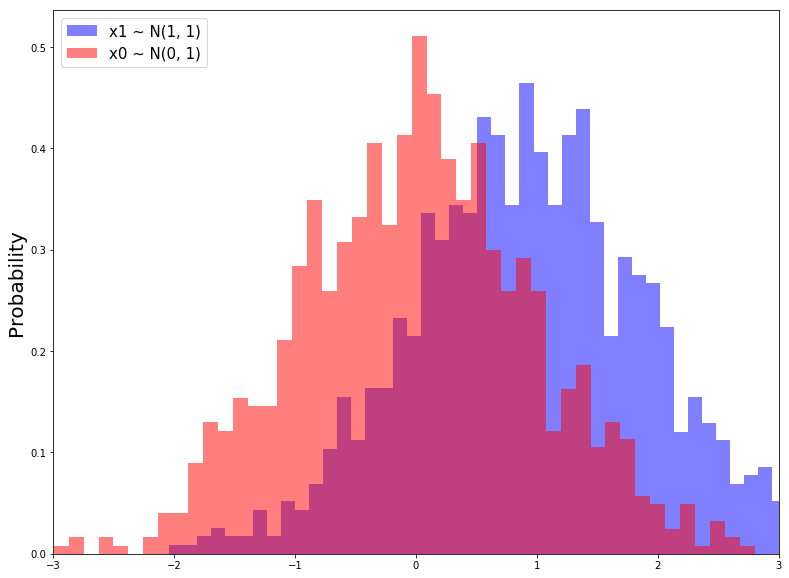

In [17]:
import numpy as np

np.random.seed(0)

x1 = np.random.normal(1, 1, 1000)
x0 = np.random.normal(0, 1, 1000)

plt.figure(figsize=(13,10))
plt.hist(x1, bins=50, normed=True, color="b", label="x1 ~ N(1, 1)", alpha=0.5);
plt.hist(x0, bins=50, normed=True, color="r", label="x0 ~ N(0, 1)", alpha=0.5);
plt.ylabel("Probability", fontsize=20);
plt.xlim(-3, 3);
plt.legend(loc="upper left", fontsize=15);

$$t_n =  \frac{\bar{x} - \mu}{\hat{\sigma}}$$
where $\bar{x}$ is sample mean and $\hat{\sigma}$ is sample standard deviation with n instances. $t_n$ is know as $n-1$ degree [t-student distribution](https://www.amazon.com/Introduction-Mathematical-Statistics-Robert-Hogg/dp/0321795431). 

In our cases, null hypothesis asserts that $x1 - x0$ is distributed according to $N(0, 1)$. Thus, we set $\mu=0$ in the above equation.

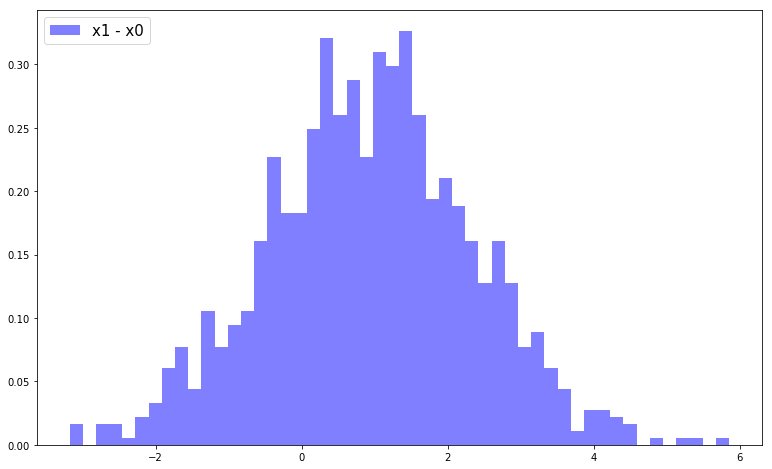

In [22]:
plt.figure(figsize=(13,8))
plt.hist(x1 - x0, bins=50, normed=True, color="b", label="x1 - x0", alpha=0.5);
plt.legend(loc="upper left", fontsize=15);

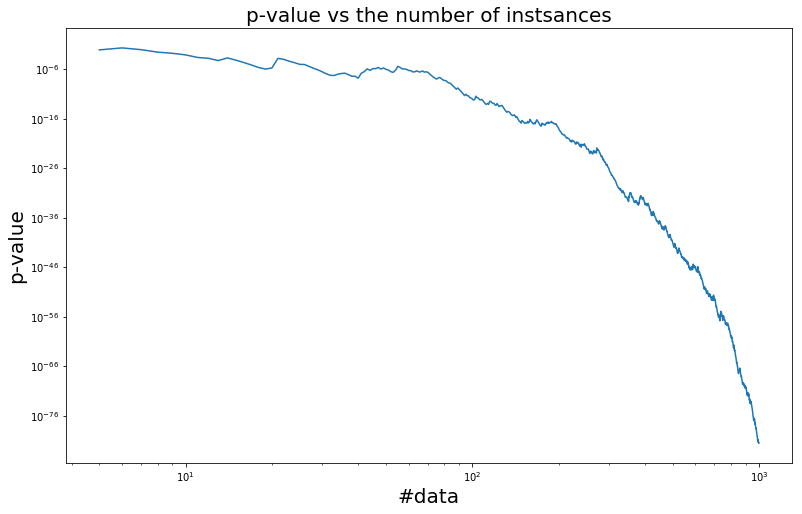

In [21]:
from scipy.stats import ttest_rel

ttest = ttest_rel(x1, x0)
ttest.pvalue
pvalues = []
idx = np.arange(5, len(x1))
for i in idx:
    ttest = ttest_rel(x1[:i], x0[:i])
    pvalues.append(ttest.pvalue)

plt.figure(figsize=(13,8))
plt.plot(idx, pvalues);
plt.ylabel("p-value", fontsize=20);
plt.xlabel("#data", fontsize=20);
plt.title("p-value vs the number of instsances", fontsize=20)
plt.xscale("log")
plt.yscale("log")

Above two graphs show that difference distribution and the variation of p-value as the number of data grows. As we can see, test shows high p-value when the number of instances is small. Then, p-value decreases as we get more evidence. Intuitive comprehension of this result is that the null hypothesis puts small probability to each instance, which leads to exponential decrease of likelihood every time a new evidence is added. As a result, p-value decreases exponentially as well.

# Bootstrap

When estimating some statistic, we can get the similar estimation from the different distribution. For example, estimating means of samples coming from $N(0, 0.1)$ and $N(0, 10^6)$ is more likely to produce the same results. The mean estimation for the first distribution is more likely to settle down to region close to truth value, 0, but that for the latter has high probability to deviate from truth value. That means even if you get a value away from 0 for the high variance distribution, it is not necessary appropriate to reject the hypothesis that its mean is 0. 

To deal with this situation, we have two approaches: model-based and nonparametric approach. Bootstrap is classified as the latter, which does not require assuming a certain form of distribution. We focus on explaining this method.

Let $(X_1, X_2, \dots, X_n)$ be a sample from the actual distribution and let be the number of instances in the sample. We take the following procedures:

1. Resample n instances from empilical distribution $(X_1^b, X_2^b, \dots, X_n^b)$, e.g., $(X_3, X_3, X_1, X_6, X_5, X_6)$ for $n=6$. 
2. Estimation from resampled instances, $\hat{\theta^b} = f_n(X_1^b, X_2^b, \dots, X_n^b)$, e.g., $f_n(X_1^b, X_2^b, \dots, X_n^b) = \frac{1}{n}\sum_{i=1}^n X_i^b$ for mean estimation
3. Repeat 1 and 2 $B$ times, e.g., $B=1000$.

Note that the number of instances in the original sample and resampled one have to be the same. After going through 1-3, we have estimations of resampled sets, $(\hat{\theta^1}, \hat{\theta^2}, \dots, \hat{\theta^B})$.

## - Example

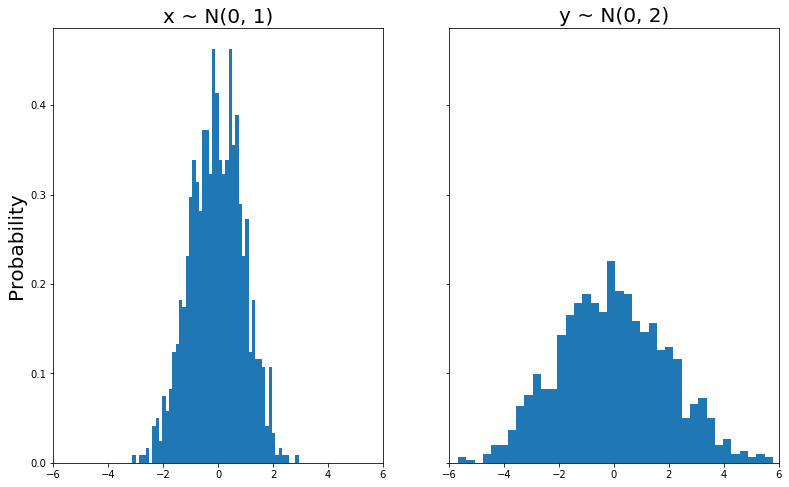

In [23]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.normal(0 ,1 , 1000)
y = np.random.normal(0 , 2 , 1000)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 8))
ax1.hist(x, bins=50, normed=True);
ax1.set_title("x ~ N(0, 1)", fontsize=20)
ax1.set_ylabel("Probability", fontsize=20)
ax1.set_xlim(-6, 6);
ax2.hist(y, bins=50, normed=True);
# ax2.set_ylabel("Probability")
ax2.set_title("y ~ N(0, 2)", fontsize=20)
ax2.set_xlim(-6, 6);


These figures are the histograms sampled from $N(0, 1)$ and $N(0, 2)$ respectively. The number of instances for each sample is $n=10^4$. If you take just mean of samples, both means of original distributions are the same and sample means are identical in the limit of $n \rightarrow \infty$. 

Let's consider the case when $n=100$.

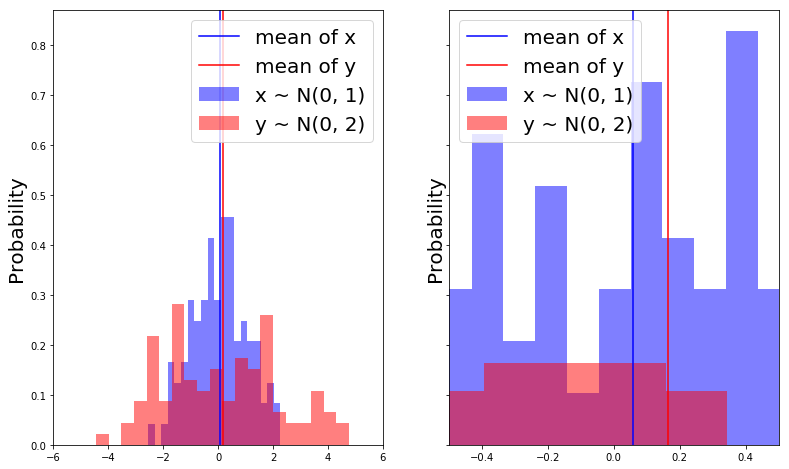

In [24]:
np.random.seed(0)
x = np.random.normal(0 ,1 , 100)
y = np.random.normal(0 , 2 , 100)

mean_x = np.mean(x)
mean_y = np.mean(y)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 8))
ax1.hist(x, bins=20, normed=True, color="b", label="x ~ N(0, 1)", alpha=0.5);
ax1.axvline(x=mean_x, color="b", alpha=1.0, label="mean of x");
ax1.hist(y, bins=20, normed=True, color="r", label="y ~ N(0, 2)", alpha=0.5);
ax1.axvline(x=mean_y, color="r", alpha=1.0, label="mean of y");
ax1.set_ylabel("Probability", fontsize=20);
ax1.set_xlim(-6, 6);
ax1.legend(fontsize=20);

ax2.hist(x, bins=50, normed=True, color="b", label="x ~ N(0, 1)", alpha=0.5);
ax2.axvline(x=mean_x, color="b", alpha=1.0, label="mean of x");
ax2.hist(y, bins=50, normed=True, color="r", label="y ~ N(0, 2)", alpha=0.5);
ax2.axvline(x=mean_y, color="r", alpha=1.0, label="mean of y");
ax2.set_ylabel("Probability", fontsize=20);
ax2.set_xlim(-0.5, 0.5);
ax2.legend(fontsize=20);

While both have the 0 mean as the true value, the uncertainties of their estimations are different. This kind of uncertainty is often estimated as confidence intervals, which indicate the possible range of true value. 95% percentage confidence interval is often used, which is the range where true value falls in with 95% probability. Bootstrap allows us to estimate confidence interval without assuming explicit models. 

For $\alpha > 0$ ($\alpha = 0.05$ for 95%), we have $M = [(\alpha / 2)B]$ and 
$$(\hat{\theta}^{M}, \hat{\theta}^{B+1 - M})$$

Let's consider the case $x$ ~ $N(0, 1)$ and $y$ ~ $N(0, 2)$ again.

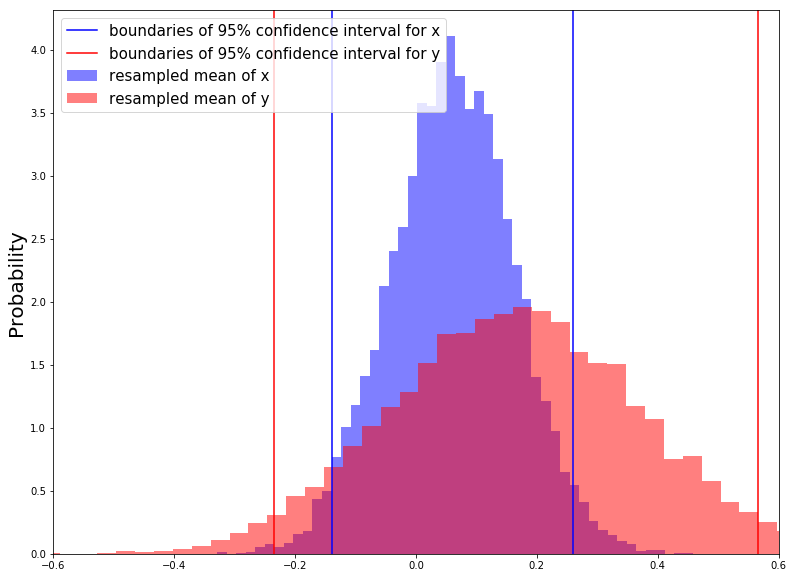

In [25]:
from sklearn.utils import resample

B = 10000
stats_x = []
stats_y = []
for i in range(B):
    stats_x.append(np.mean(resample(x, replace=True, n_samples=x.shape[0])))
    stats_y.append(np.mean(resample(y, replace=True, n_samples=y.shape[0])))

num_data = len(stats_x)
alpha = 0.05
low_idx = int(num_data * alpha * 0.5)
high_idx = int(num_data * (1 - alpha * 0.5))

sort_idx = np.argsort(stats_x)
low_x = stats_x[sort_idx[low_idx]]
high_x = stats_x[sort_idx[high_idx]]

sort_idx = np.argsort(stats_y)
low_y = stats_y[sort_idx[low_idx]]
high_y = stats_y[sort_idx[high_idx]]

plt.figure(figsize=(13,10))
plt.hist(stats_x, bins=50, normed=True, color="b", label="resampled mean of x", alpha=0.5);
plt.axvline(x=low_x, color="b", alpha=1.0, label="boundaries of 95% confidence interval for x");
plt.axvline(x=high_x, color="b", alpha=1.0);
plt.hist(stats_y, bins=50, normed=True, color="r", label="resampled mean of y", alpha=0.5);
plt.axvline(x=low_y, color="r", alpha=1.0, label="boundaries of 95% confidence interval for y");
plt.axvline(x=high_y, color="r", alpha=1.0);
plt.ylabel("Probability", fontsize=20);
plt.xlim(-0.6, 0.6);
plt.legend(loc="upper left", fontsize=15);

As you see in the graph, $y$ has wider confidence interval than $x$, which indicates uncertainty of estimation due to high variance. 

# Hypothesis Test Using Bootstrap

As an application of bootstrap to hypothesis test, we consider test of significance of mean difference. Let $x$ and $y$ be distributed according to the distribution with mean $\mu_1$ and the distribution with mean $\mu_2$, respectively. We set null Hypothesis, $H_0: \mu_1 \leq \mu_2$ and alternative hypothesis, $H_1: \mu_1 > \mu_2$. We take n samples for each of them: $\mathbf{X} = (x_1, x_2, \dots, x_{n})$ and $\mathbf{Y} = (y_1, y_2, \dots, y_{n})$.

Since it is enough to consider the the equivalent mean case for null hypothesis, we first assume $\mu_1 = \mu_2$. Under this assumption, we build the empirical distribution by concatenating $X$ and $Y$. Then, we estimate p_value by resampling. The algorithm is the following:

1. Compute the difference between empirical means $\bar{x} - \bar{y}$
2. Concatenate $\mathbf{X}$ and $\mathbf{Y}$ $\rightarrow$ $\mathbf{Z} = (z_1, z_2, \dots, z_{2n})$, where $z_{i}=x_i$ and $z_{i+1000}=y_i$ for $1 \leq i \leq n$.
3. Resample $\mathbf{X}^{*b} = (x_1^{*b}, x_2^{*b}, \dots, x_{n}^{*b})$ and $\mathbf{Y}^{*b} = (y_1^{*b}, y_2^{*b}, \dots, y_{n}^{*b})$ from $\mathbf{Z}$. 
4. Compute the difference between empirical means of $\mathbf{X}^{*b}$ and $\mathbf{Y}^{*b}$: $\bar{x}^{*b} - \bar{y}^{*b}$.
5. Repeat 3 and 4 $B$ times
6. Compute p-value $= \frac{1}{B} \#_{b=1}^B \{v_j \geq v\}$.

## - Example

Let actual values of $\mu_1$ and $\mu_2$ be 1 and 0, respectively. We set $\sigma = 1$ and take 1000 samples for each random variables x and y. 

In [245]:
from sklearn.utils import resample

def bootstrap(x, y, B):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    true_mean = mean_y - mean_x
    stats_mean = []
    idx = np.arange(x.shape[0])
    p_values = []
    z = np.concatenate((x, y))
    for i in range(B):
        resampled_x = resample(z, replace=True, n_samples=z.shape[0])
        resampled_y = resample(z, replace=True, n_samples=z.shape[0])
        est_mean = np.mean(resampled_y - resampled_x)
        stats_mean.append(est_mean)
        if true_mean <= est_mean:
            p_values.append(1)
        else:
            p_values.append(0)
    p_value = np.mean(p_values)
    return p_value

np.random.seed(10)
x = np.random.normal(0 ,1 , 1000)
y = np.random.normal(0.1 , 1 , 1000)
B = 100000
print("p-value = %f" % bootstrap(x, y, B))

p-value = 0.000380


We got 0.00038 as p-value. If we set $\alpha=0.05$, we reject null hypothesis. Note that bootstrap is nonparametric method, which implies that the distribution is not necessary Gaussian distribution. We don't have to know even the analytical the distribution function.

# Reality Check (RC) and Superior Predictive Ability (SPA)

As we discussed before, financial data is one sample path and high variance. To deal with these difficulties, time series bootstrap method called reality check (RC) has been introduced by [White(2000)](http://www.ssc.wisc.edu/~bhansen/718/White2000.pdf). This method has been modified by [Hansen(2005)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.485.5482&rep=rep1&type=pdf), who gives stronger ability to reject alternative hypothesis when mean value is strictly negative. This method is called a test for Superior Predictive Ability (often denoted by SPA).

In the following discussion, $d_{k, i}$ denotes the performance of algorithm k subtracted by benchmark at time i. We also use $n$ as a time period and $m$ as the number of algorithms. The difference between RC and SPA comes from the statics to compare:

$$T^{RC}_n = max \big[ \underset{k = 1, \dots, m}{max}\ n^{1/2} \bar{d}_k, 0\big]$$
$$T^{SPA}_n = max \big[ \underset{k = 1, \dots, m}{max}\{\frac{n^{1/2} \bar{d}_k}{\hat{\omega}_k}\}, 0\big]$$
Note that we define $T^{RC}_n$ to take only positive values for the sake of simplicity, which is different from the one defined by [White](http://www.ssc.wisc.edu/~bhansen/718/White2000.pdf). We explore bootstrap method for RC and SPA. 

Bootstrap resamples from the empirical distribution by mixing the order of samples. Time series data, however, has historical dependency in general, which makes normal bootstrap improper. The variation of bootstrap for time series data has been proposed by [Politis and Romano(1994)](http://www.tandfonline.com/doi/abs/10.1080/01621459.1994.10476870), which is called the stationary bootstrap. 

Let $b \in (1, \infty)$ and let $n$ be the number of samples. Then, here is the the stationary bootstrap:

1. Take a random initial position for $\theta(1)$
2. Take a random position for $\theta(t + 1)$ with probability $1 - \frac{1}{b}$ or set $\theta(t + 1) = \theta(t) + 1$ with probability $\frac{1}{b}$ for $1 < t \leq n$.
3. Repeat 1. and 2. B times

This method is based on resampling random variable length subset of time series data. Note that parameter $b$ corresponds to the average length of these subsets. The distribution of the stationary bootstrap is known to converge to the original distribution as $b \rightarrow \infty$ and $n \rightarrow \infty$ in distribution under certain conditions, [White(2000)](http://www.ssc.wisc.edu/~bhansen/718/White2000.pdf). Thus, the stationary bootstrap is is statistically sound resampling method for time series data.

We now work on bootstrap hypothesis test proposed by White in [the paper](http://www.ssc.wisc.edu/~bhansen/718/White2000.pdf).

Let $\{d_{k, t}\}_{t=1}^n$ be the performance of the algorithm $k$ subtracted by the benchmark for $k=1, \dots, m$. We denote sample means by $\bar{d}_k = \sum_{t=1}^n d_{k, t}$. 

1. Compute $\bar{V}_k = max\{n^{1/2}\bar{d}_k, \bar{V}_{k-1}\}$ for $k=2, \dots, m$ and $\bar{V}_1 = max\{n^{1/2}\bar{d}_1, 0\}$.
2. Resample $(d_{k, t}^1, d_{k, t}^2, \dots, d_{k, t}^B)$ and compute $\bar{d}^*_{k, b} = \sum_{t=1}^n d^b_{k, t}$.
3. We denote by $\bar{V}^*_{k, b} = max\{n^{1/2}(\bar{d}^*_{k, b} - \bar{d}_k), \bar{V}^*_{k-1, b}\}$ for $k=2, \dots, m$ and $\bar{V}^*_{1, b} = max\{n^{1/2}(\bar{d}^*_{1, b} - \bar{d}_1), 0\}$ and compute them for for $b=1, \dots, B$.
4. Let $M_{\alpha}$ be $\bar{V}^*_{k, M_{\alpha}} \leq \bar{V}_{k} < \bar{V}_{k, M_{\alpha}+1}$ and compute $P_{RC} = 1 - M_{\alpha}/B$.
5. If $P_{RC} \leq \alpha$, reject null hypothesis.

$P_{RC}$ is the p-value calculated by the stationary bootstrap. Intuitively, $P_{RC}$ is the cumulative distribution greater than threshold for the null hypothesis distribution, which is calculated by recentered statistics, $\bar{V}^*_{k, b}$.

When mean is slightly positive, it is difficult to reject null hypothesis. SPA has improved this point by introducing modified null hypothesis mean value $\hat{\mu}_k^c$.

$$T^{SPA}_n = max \big[ \underset{k = 1, \dots, m}{max}\{\frac{n^{1/2} \bar{d}_k}{\hat{\omega}_k}\}, 0\big]$$
$$ \hat{\mu}_k^c = \bar{d}_k 1_{\left\{\ n^{1/2} \bar{d}_k / \hat{\omega}_k \leq -\sqrt{2log\ log\ n}\ \right\}}$$

When approximating samples from null hypothesis, RC recenters with subtracting by sample mean. If true mean is slightly positive, it has high probability to end up negative values, which makes resampling positively biased, As a result, this makes it difficult to reject null hypothesis. To overcome this, [Hansen(2005)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.485.5482&rep=rep1&type=pdf) introduces the modification inspired by [the law of the iterated logarithm](https://en.wikipedia.org/wiki/Law_of_the_iterated_logarithm), which asserts that $-\sqrt{2log\ log\ n}$ is the growth speed of infimum in the limit. More precisely, for a distribution with finite mean and variance, it is known that 

$$ P\big(\ \underset{n \rightarrow \infty}{lim \ inf}\ \frac{n^{1/2} (\bar{x} - \mu)}{\hat{\sigma}} = -\sqrt{2 log\ log\ n}\ \big) = 1$$

where $\bar{x}$ is sample mean, $\mu$ is true mean, and $\hat{\sigma}$ is sample deviation. Thus, in the above equation, $n^{1/2} \bar{d}_k / \hat{\omega}_k$ grows slower to negative direction than $-\sqrt{2log\ log\ n}$ if mean is equivalent to or greater than 0. Then, Hansen modifies mean to 0 for null hypothesis if growth rate is slow. 

The bootstrap method is the same as RC except for the point: using $\bar{Z}^*_{k, b} = max\{\frac{n^{1/2}(\bar{d}^*_{k, b} - \hat{\mu}_k^c)}{\hat{\omega}_k}, \bar{Z}^*_{k-1, b}\}$instead of $\bar{V}^*_{k, b}$

In [the original paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.485.5482&rep=rep1&type=pdf), $\hat{\mu}_k^l$ and $\hat{\mu}_k^u$ are introduced as lower bound and upper bound of null hypothesis mean. Effective estimating $\hat{\omega}_k$ is also explained. If you have interest, refer to [the original paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.485.5482&rep=rep1&type=pdf).

## - Example

For the pedagogical reason, we use Markov process, which depends only on the most recent history. Note that if the distribution is actually Markov chain, there is no reason to use the stationary bootstrap. 

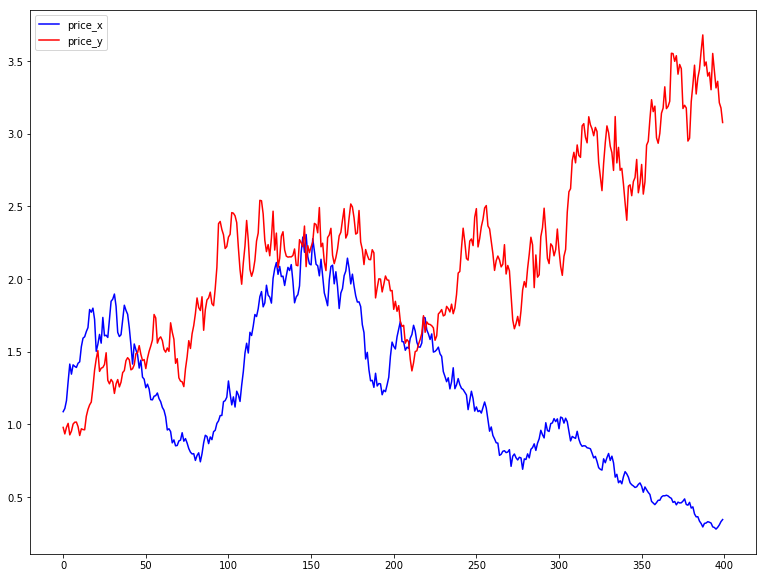

In [26]:
np.random.seed(0)

return_x = np.random.normal(0, .05, 400)
return_y = np.random.normal(0.01, .05, 400)

price_x = np.cumprod(1 + return_x)
price_y = np.cumprod(1 + return_y)

plt.figure(figsize=(13,10))
plt.plot(price_x, color="b", label="price_x");
plt.plot(price_y, color="r", label="price_y");
plt.legend();

We use an open source implementation [arch](https://github.com/bashtage/arch), a library for time series analysis including ARCH, GARCH, SPA, etc.

In [298]:
from arch.bootstrap import SPA

np.random.seed(0)
# first two arguments should be benchmark and model
spa = SPA(return_y, return_x, block_size=100, reps=1000, 
          bootstrap="stationary", studentize=True)
spa.compute()
print("p-values of SPA:")
print(spa.pvalues)

p-values of SPA


lower         0.018
consistent    0.018
upper         0.018
dtype: float64

# Wrap up

We have gone through basic concept of hypothesis test for time series based on bootstrap. I briefly explain without mathematical detail and focuses on making concepts understandable intuitively. If you notice some typos or other mistakes, feel free to contact me. I am also glad if I get suggestions to improve and open to discussions. 